In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-in-csv/mnist_test.csv
/kaggle/input/mnist-in-csv/mnist_train.csv


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [12]:
class CSVDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        self.data = df[(df['label'] ==5) | (df['label'] ==6) | (df['label'] ==7) | (df['label'] ==0) | (df['label'] ==2)]
        self.X = self.data.iloc[:, :-1].values
        label_map = {0: 0, 2: 1, 5: 2, 6: 3, 7: 4}
        self.y = self.data['label'].map(label_map).values
        #self.y = self.data.iloc[:, -1].values
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

In [13]:
train_dataset = CSVDataset('/kaggle/input/mnist-in-csv/mnist_train.csv')
test_dataset = CSVDataset('/kaggle/input/mnist-in-csv/mnist_test.csv')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
class trainable_Activation(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(4))

    def forward(self, x):
        return (
            self.alpha[0]*F.relu(x) + 
            self.alpha[1]*torch.sigmoid(x)+
            self.alpha[2]*torch.tanh(x)+
            self.alpha[3]*F.silu(x)
        )
        

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, activation_name):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.activation = trainable_Activation()
            
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        #x = F.softmax(x, dim=1)
        return x

def train_model(model, optimizer, criterion, epochs=50):
    criterion = nn.CrossEntropyLoss()
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss+=loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_test_loss +=loss.item()
    
                _, predicted = torch.max(outputs.data, 1)
                correct_test+=(predicted==labels).sum().item()
                total_test +=labels.size(0)
            
        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = correct_test / total_test
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
    
        print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}% | "
                  f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy*100:.2f}%")

    return train_losses, test_losses, train_accuracies, test_accuracies



In [17]:
model = NeuralNetwork(28*28, 128, 64, 5, 'relu').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
train_losses, test_losses_, train_acc, test_acc = train_model(model, optimizer, criterion, epochs=50)

Epoch 1/50 | Train Loss: 0.5941, Train Acc: 94.66% | Test Loss: 0.1756, Test Acc: 96.69%
Epoch 2/50 | Train Loss: 0.1088, Train Acc: 97.51% | Test Loss: 0.1376, Test Acc: 97.24%
Epoch 3/50 | Train Loss: 0.0672, Train Acc: 98.24% | Test Loss: 0.1107, Test Acc: 97.46%
Epoch 4/50 | Train Loss: 0.0519, Train Acc: 98.48% | Test Loss: 0.1099, Test Acc: 97.32%
Epoch 5/50 | Train Loss: 0.0469, Train Acc: 98.71% | Test Loss: 0.0911, Test Acc: 97.28%
Epoch 6/50 | Train Loss: 0.0365, Train Acc: 98.79% | Test Loss: 0.0753, Test Acc: 98.32%
Epoch 7/50 | Train Loss: 0.0319, Train Acc: 98.99% | Test Loss: 0.0540, Test Acc: 98.59%
Epoch 8/50 | Train Loss: 0.0273, Train Acc: 99.18% | Test Loss: 0.0606, Test Acc: 98.28%
Epoch 9/50 | Train Loss: 0.0247, Train Acc: 99.21% | Test Loss: 0.0541, Test Acc: 98.45%
Epoch 10/50 | Train Loss: 0.0218, Train Acc: 99.29% | Test Loss: 0.0573, Test Acc: 98.57%
Epoch 11/50 | Train Loss: 0.0188, Train Acc: 99.43% | Test Loss: 0.0686, Test Acc: 98.47%
Epoch 12/50 | Train

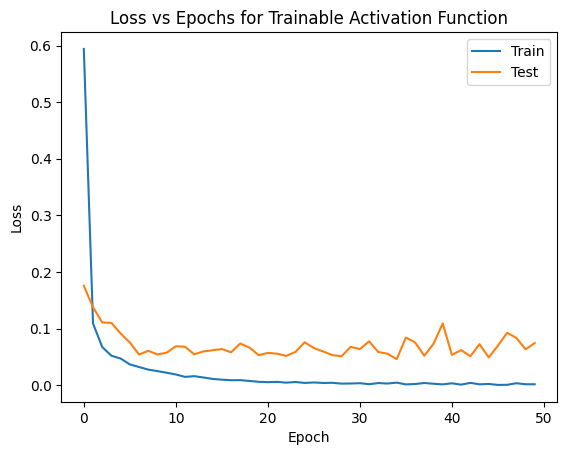

In [20]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train')
plt.plot(test_losses_, label='Test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs for Trainable Activation Function")
plt.legend()
plt.show()


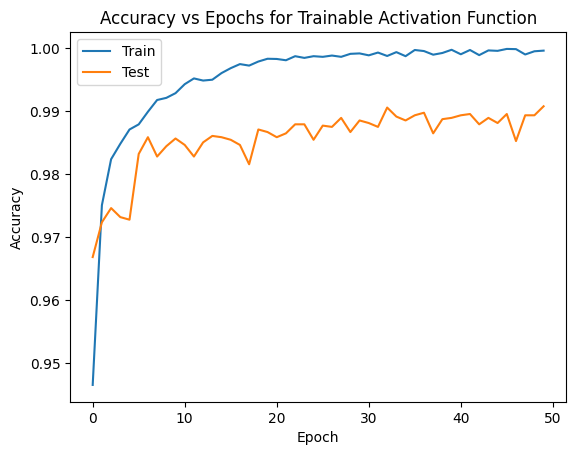

In [21]:

plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs for Trainable Activation Function")
plt.legend()
plt.show()
